# Sample xarray reps of VELMOD and DGM

## Intro

In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('..'))

In [3]:
import numpy as np
import pandas as pd
import xarray as xr
import pyproj as prj
import matplotlib.pyplot as plt
from preseis.dgm_velmod_sampler import sample_dgm_velmod

Read VELMOD and DGM in xarray format. Use the `decode_coords="all"` option for loading georeferenced data optimally (https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html).

In [5]:
velmod = xr.load_dataset("../build/output/VELMOD31_UTM31.h5", decode_coords="all")
dgm = xr.load_dataset("../build/output/DGM5_UTM31.h5", decode_coords="all")

Prepare coordinate transformers

In [11]:
crs_GPS, crs_UTM, crs_RD = (
    prj.CRS("EPSG:4326"),
    prj.CRS("EPSG:23031"),
    prj.CRS("EPSG:28992"),
)
RD_to_UTM = prj.Transformer.from_crs(crs_RD, crs_UTM)
RD_to_GPS = prj.Transformer.from_crs(crs_RD, crs_GPS)
UTM_to_RD = prj.Transformer.from_crs(crs_UTM, crs_RD)
UTM_to_GPS = prj.Transformer.from_crs(crs_UTM, crs_GPS)
GPS_to_UTM = prj.Transformer.from_crs(crs_GPS, crs_UTM)
GPS_to_RD = prj.Transformer.from_crs(crs_GPS, crs_RD)


## Create Vinst grid in RD coordinates

Define grid in RD

In [13]:
# X,Y samples
xsmp_RD, dx = np.linspace(100000.0, 112000.0, 241, retstep=True)
ysmp_RD, dy = np.linspace(500000.0, 512000.0, 241, retstep=True)
zsmp, dz = np.linspace(-6000.0, 0.0, 121, retstep=True)

Prepare xarray representation, without data, just coordinates

In [14]:
grid = xr.Dataset(
    coords={
        "x": xsmp_RD,
        "y": ysmp_RD,
        "z": zsmp
        }
    )\
    .rio.write_crs(crs_RD.to_epsg())\
    .rio.write_coordinate_system()

Determine UTM coordinates for all grid points

In [15]:
x_UTM, y_UTM = xr.apply_ufunc(
    RD_to_UTM.transform,
    grid["x"], grid["y"],
    output_core_dims=[[], []],
    vectorize=True, # prj Transformers do not broadcast
    keep_attrs=True
    )

Sample models to cube, no need to pass CRS since it is represented in the x_UTM data structure

In [16]:
dgm_velmod_cube = sample_dgm_velmod(x_UTM, y_UTM, grid["z"], dgm=dgm, velmod=velmod)

In [17]:
dgm_velmod_cube

<xarray.Dataset>
Dimensions:       (unit: 11, x: 241, y: 241, z: 121)
Coordinates:
  * unit          (unit) object 'NU' 'NLNM' 'CK' 'KN' ... 'RB' 'ZE' 'RO' 'DC'
  * x             (x) float64 1e+05 1e+05 1.001e+05 ... 1.12e+05 1.12e+05
  * y             (y) float64 5e+05 5e+05 5.001e+05 ... 5.12e+05 5.12e+05
  * z             (z) float64 -6e+03 -5.95e+03 -5.9e+03 ... -100.0 -50.0 0.0
    spatial_ref   int64 0
Data variables:
    V0            (x, y, unit) float64 1.73e+03 1.822e+03 ... 3.651e+03
    V0_sd         (x, y, unit) float64 65.34 75.32 184.5 ... 201.3 189.1 188.7
    k             (unit) float64 0.436 0.235 0.889 0.536 ... 0.0 0.309 0.261
    depth         (x, y, unit) float64 -902.7 -1.002e+03 ... -2.701e+03 -inf
    ordering      (unit) int32 1 2 5 6 10 15 17 18 19 20 22
    unit_samples  (z, x, y) object 'DC' 'DC' 'DC' 'DC' ... 'NU' 'NU' 'NU' 'NU'
    unit_mask     (unit, z, x, y) bool False False False ... False False False
    Vinst         (x, y, z) float64 5.193e+03 5.18e+03 ... 1.724e+03 1.702e+03

Plot just some slices

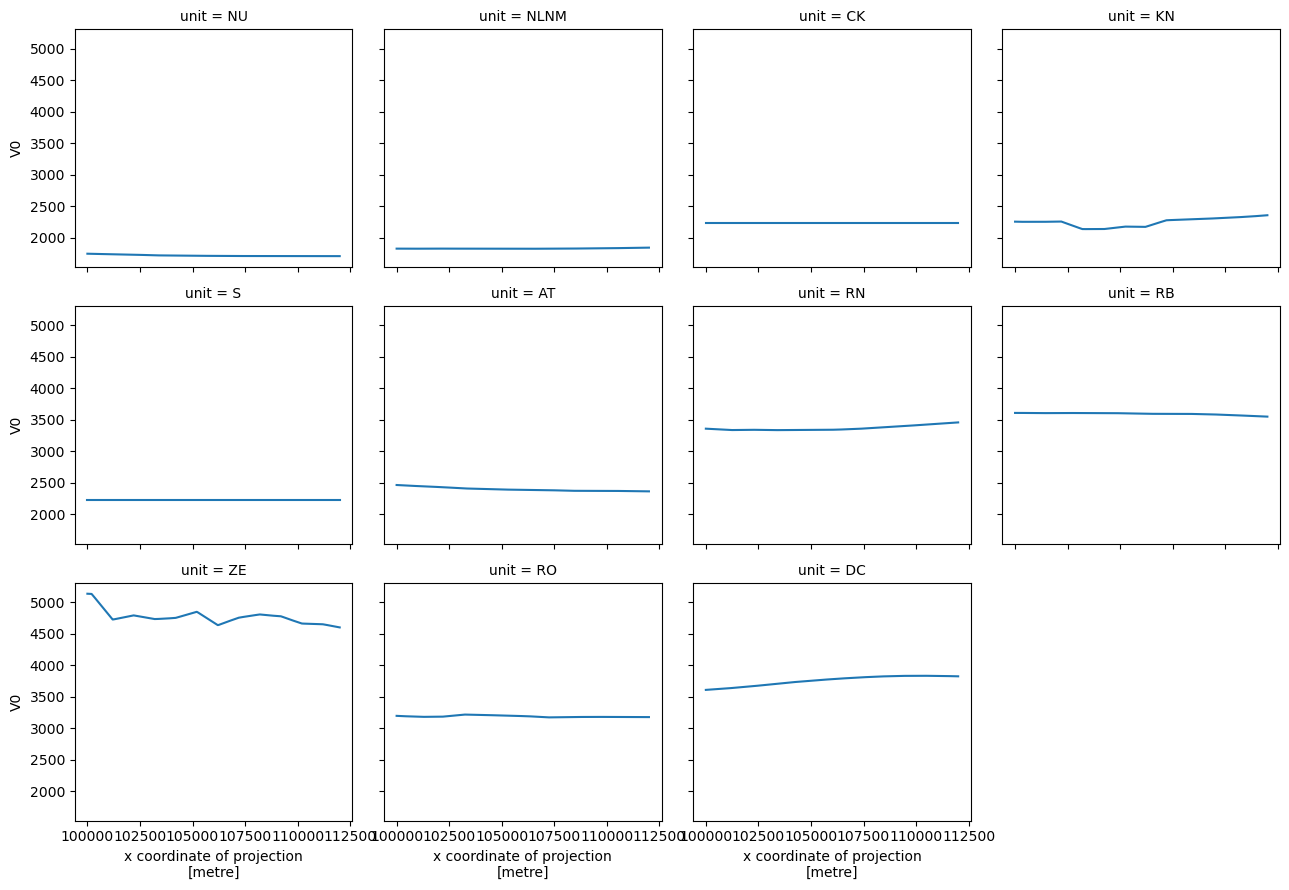

In [18]:
dgm_velmod_cube["V0"]\
    .isel({"y":100})\
    .plot(x="x", col="unit", col_wrap=4)

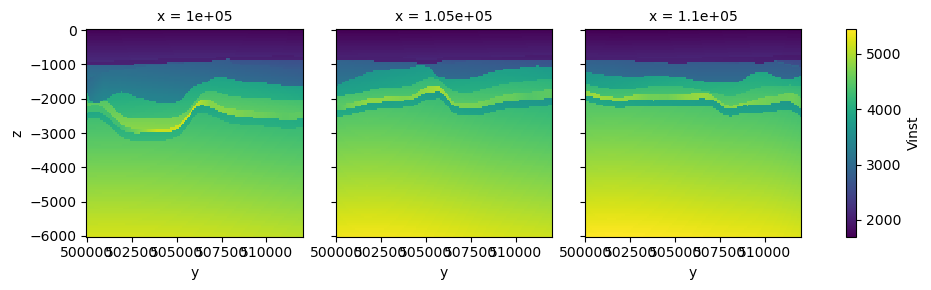

In [24]:
dgm_velmod_cube["Vinst"]\
    .thin({"x": 100}).plot(x="y", y="z", col="x")


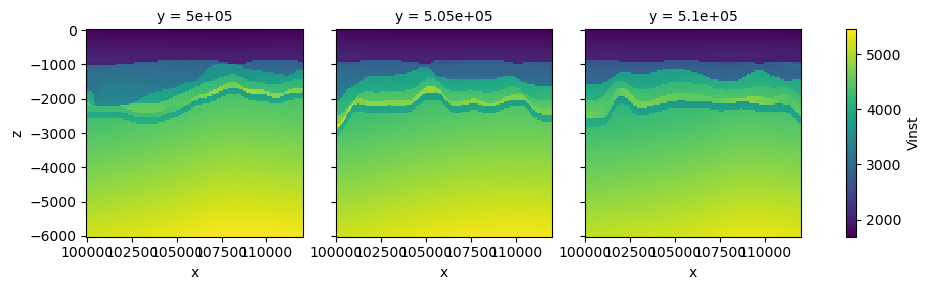

In [19]:
dgm_velmod_cube["Vinst"].thin({"y": 100}).plot(x="x", y="z", col="y")

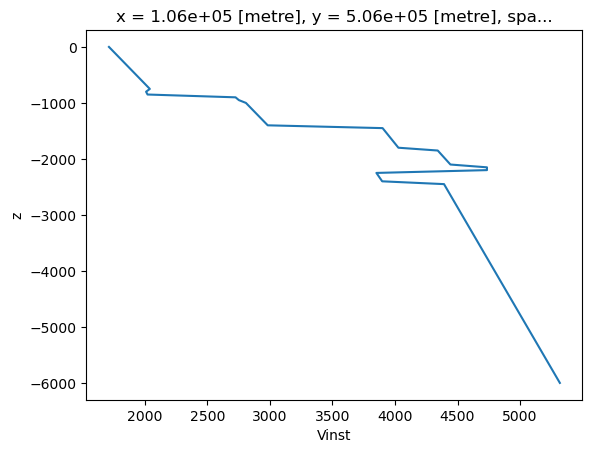

In [20]:
dgm_velmod_cube["Vinst"].isel({"x": 121, "y": 121}).plot.line(y="z")

## Create Vinst profiles for stations from KNMI

Read station list from KNMI FDSN web service

In [21]:
link = "http://rdsa.knmi.nl/fdsnws/station/1/query?network=NL&format=text"
knmi_stations = xr.Dataset(pd.read_csv(link, sep="|", index_col=1))

In [22]:
knmi_stations

<xarray.Dataset>
Dimensions:    (Station: 830)
Coordinates:
  * Station    (Station) object '0171' '1979' '1980' ... 'ZWE2' 'ZWE3' 'ZWE4'
Data variables:
    #Network   (Station) object 'NL' 'NL' 'NL' 'NL' 'NL' ... 'NL' 'NL' 'NL' 'NL'
    Latitude   (Station) float64 51.04 50.97 50.8 50.87 ... 53.19 53.19 53.19
    Longitude  (Station) float64 5.869 5.927 5.973 6.085 ... 5.604 5.604 5.604
    Elevation  (Station) float64 35.0 80.0 154.0 145.0 1.0 ... 0.0 0.0 0.0 0.0
    SiteName   (Station) object 'Nieuwstadt' 'Bingelrade' ... 'Zweins niveau 4'
    StartTime  (Station) object '2006-01-27T00:00:00' ... '2010-03-24T00:00:00'
    EndTime    (Station) object '2011-11-25T00:00:00' ... nan

Extend station dataset with UTM and RD coordinates

In [23]:
knmi_stations["x"], knmi_stations["y"] = xr.apply_ufunc(
    GPS_to_RD.transform,
    knmi_stations["Latitude"],
    knmi_stations["Longitude"],
    output_core_dims=[[], []],
)
knmi_stations["x_UTM"], knmi_stations["y_UTM"] = xr.apply_ufunc(
    GPS_to_UTM.transform,
    knmi_stations["Latitude"],
    knmi_stations["Longitude"],
    output_core_dims=[[], []],
)
knmi_stations\
    .set_coords(["x", "y"])\
    .rio.write_crs(crs_RD.to_epsg(), inplace=True)

<xarray.Dataset>
Dimensions:      (Station: 830)
Coordinates:
  * Station      (Station) object '0171' '1979' '1980' ... 'ZWE2' 'ZWE3' 'ZWE4'
    x            (Station) float64 1.888e+05 1.929e+05 ... 1.695e+05 1.695e+05
    y            (Station) float64 3.385e+05 3.314e+05 ... 5.78e+05 5.78e+05
    spatial_ref  int64 0
Data variables:
    #Network     (Station) object 'NL' 'NL' 'NL' 'NL' ... 'NL' 'NL' 'NL' 'NL'
    Latitude     (Station) float64 51.04 50.97 50.8 50.87 ... 53.19 53.19 53.19
    Longitude    (Station) float64 5.869 5.927 5.973 6.085 ... 5.604 5.604 5.604
    Elevation    (Station) float64 35.0 80.0 154.0 145.0 1.0 ... 0.0 0.0 0.0 0.0
    SiteName     (Station) object 'Nieuwstadt' ... 'Zweins niveau 4'
    StartTime    (Station) object '2006-01-27T00:00:00' ... '2010-03-24T00:00...
    EndTime      (Station) object '2011-11-25T00:00:00' ... nan
    x_UTM        (Station) float64 7.012e+05 7.056e+05 ... 6.741e+05 6.741e+05
    y_UTM        (Station) float64 5.658e+06 5.651e+06 ... 5.897e+06 5.897e+06

In [24]:
x,y,z=knmi_stations["x_UTM"], knmi_stations["y_UTM"], grid['z']

In [25]:
# interpolate VELMOD - note that this interpolates all variables which in practive will nog be necessary
KNMI_station_profiles = sample_dgm_velmod(x, y, z, dgm=dgm, velmod=velmod)

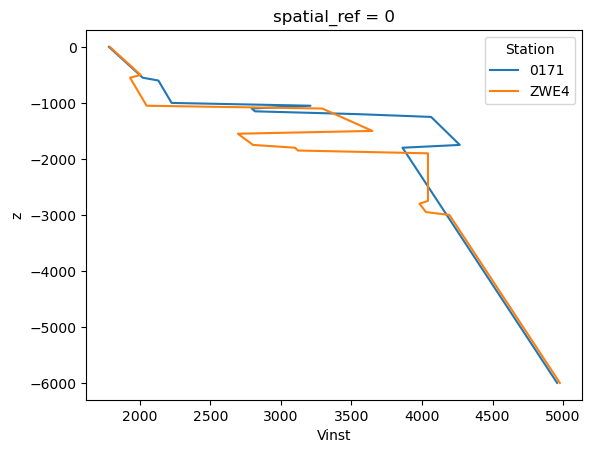

In [26]:
KNMI_station_profiles["Vinst"].sel({"Station":["0171","ZWE4"]}).plot.line(y="z");

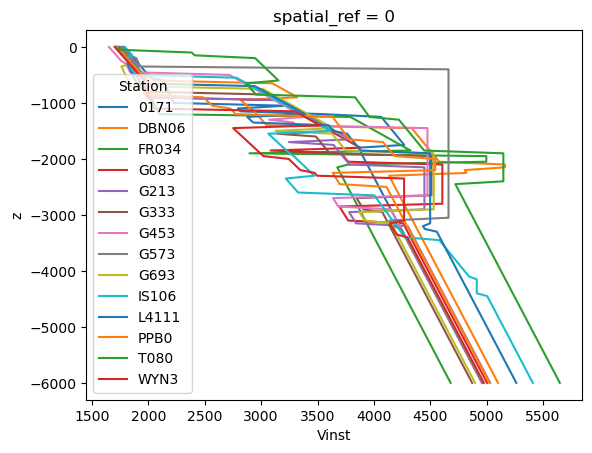

In [27]:
KNMI_station_profiles["Vinst"].thin({"Station":60}).plot.line(y="z");

## Create Vinst section in RD coordinates between two stations

In [28]:
stat1 = "G344"
stat2 = "G544"
spacing = 100.

# determine the extents of the line between the stations
x_range = knmi_stations["x"].sel({"Station":[stat1,stat2]}).values
y_range = knmi_stations["y"].sel({"Station":[stat1,stat2]}).values

# determine the total distance, make sure the number of samples along the line
# reduces the grid spacing to below the value of "spacing" set above
dist = np.linalg.norm([np.diff(x_range),np.diff(y_range)])
n = int(np.ceil(dist/spacing))

x_smp_RD = np.linspace(x_range[0], x_range[1], n)
y_smp_RD = np.linspace(y_range[0], y_range[1], n)

distance_along_line = np.sqrt((x_smp_RD - x_smp_RD[0])**2 + (y_smp_RD - y_smp_RD[0])**2)

In [29]:
x_RD_line = xr.DataArray(x_smp_RD, coords={"inline": distance_along_line})
y_RD_line = xr.DataArray(y_smp_RD, coords={"inline": distance_along_line})

x_UTM_line, y_UTM_line = xr.apply_ufunc(
    RD_to_UTM.transform,
    x_RD_line, y_RD_line,
    output_core_dims=[[], []])

In [30]:
model_RD_line = sample_dgm_velmod(x_UTM_line, y_UTM_line, z, dgm=dgm, velmod=velmod)

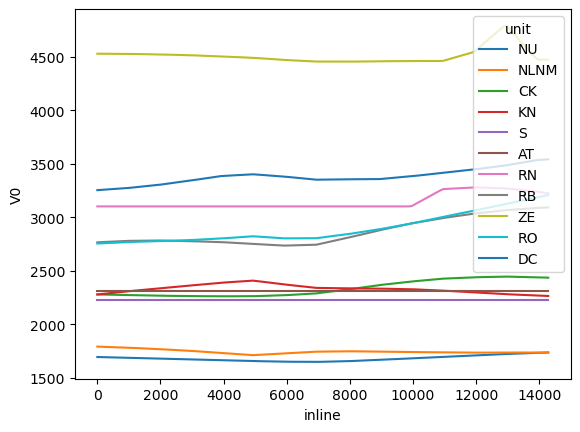

In [31]:
model_RD_line["V0"].dropna("unit").reset_coords(drop=True).plot.line(x="inline");

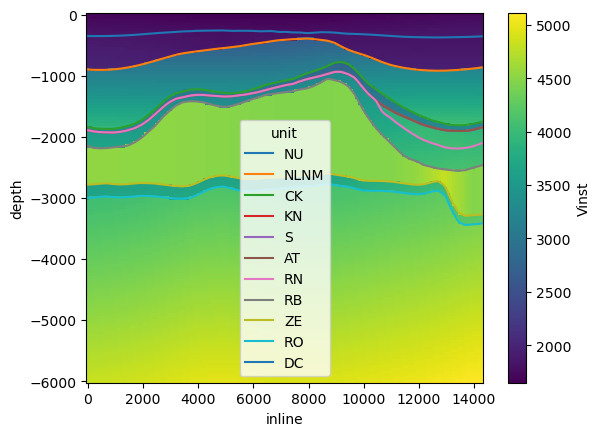

In [32]:
fig, ax=plt.subplots(ncols=1)
model_RD_line["Vinst"].reset_coords(drop=True).plot.imshow(x="inline",y="z",ax=ax)
model_RD_line["depth"].dropna("unit").reset_coords(drop=True).plot.line(x="inline",ax=ax);